# Importing Modules

In [1]:
import os
import time
from itertools import product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline

# Loading Data

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [3]:
INPUTFOLDER = '../input/competitive-data-science-predict-future-sales/'

item_categories = pd.read_csv(os.path.join(INPUTFOLDER, 'item_categories.csv'))
items           = pd.read_csv(os.path.join(INPUTFOLDER, 'items.csv'))
sales           = pd.read_csv(os.path.join(INPUTFOLDER, 'sales_train.csv'))
shops           = pd.read_csv(os.path.join(INPUTFOLDER, 'shops.csv'))
test            = pd.read_csv(os.path.join(INPUTFOLDER, 'test.csv'))

# Exploratory Data Analysis
* Plot the number of items sold from Jan to Dec for the years 2013, 2014 and 2015:

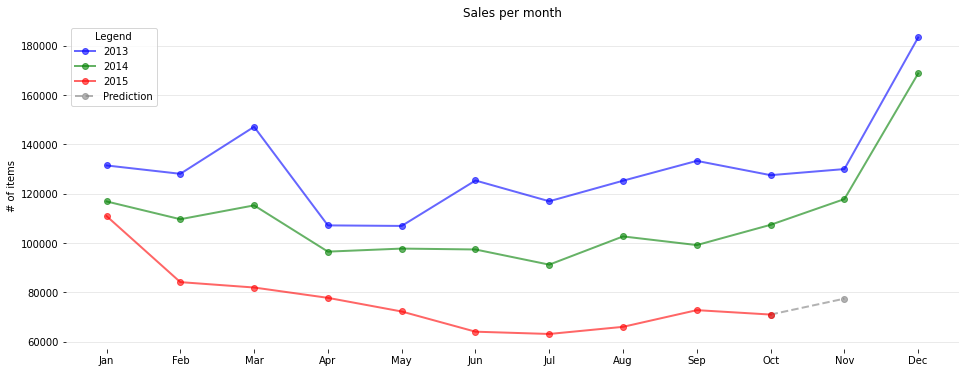

In [4]:
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
years = [2013, 2014, 2015]
LINEWIDTH=2
ALPHA=.6

dfp = sales[['date', 'date_block_num','item_cnt_day']].copy()

# Extract the year and the month from the date column into indepedent columns
dfp['date']  = pd.to_datetime(dfp['date'], format='%d.%m.%Y')
dfp['year'], dfp['month']  = dfp['date'].dt.year, dfp['date'].dt.month
dfp.drop(['date'], axis=1, inplace=True)

# Sum the number of sold items for each date_block_num (which is the consecutive month number from January 2013 to October 2015)
dfp = dfp.groupby('date_block_num', as_index=False)\
       .agg({'year':'first', 'month':'first', 'item_cnt_day':'sum'})\
       .rename(columns={'item_cnt_day':'item_cnt_month'}, inplace=False)

color={
    '2013':'blue',
    '2014':'green',
    '2015':'red',
}

plt.figure(figsize=(16,6))

# Plot the sales of the year 2013-2015
for _year in years:
    plt.plot(MONTHS if _year!=2015 else MONTHS[:10], dfp[dfp.year==_year].item_cnt_month, '-o', color=color[str(_year)], linewidth=LINEWIDTH, alpha=ALPHA,label=str(_year))

# Capturing the trend between October and November (For year 2013 and 2014)
delta_2013 = dfp.iloc[10].item_cnt_month - dfp.iloc[9].item_cnt_month
delta_2014 = dfp.iloc[22].item_cnt_month - dfp.iloc[21].item_cnt_month
avg_delta = (delta_2013 + delta_2014) / 2
# Add the average to the previous month (October 2015)
nov_2015 = dfp.iloc[33].item_cnt_month + avg_delta

# ['Oct', 'Nov']
plt.plot(MONTHS[9:11], [dfp.iloc[33].item_cnt_month, nov_2015], '--o', color='gray', linewidth=LINEWIDTH, alpha=ALPHA, label='Prediction', zorder=-1)
del dfp
# Axes parameters
ax = plt.gca()
ax.set_title('Sales per month')
ax.set_ylabel('# of items')
ax.grid(axis='y', color='gray', alpha=.2)
    
# Remove the frame off the chart
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.legend(loc=2, title='Legend')
plt.show()

* Top-N Selling Categories for each year

2013: the total of the top 15 best selling items is 1304004 over a total of 1565897 for that year, which represents 83.28%
2014: the total of the top 15 best selling items is 1048377 over a total of 1323594 for that year, which represents 79.21%
2015: the total of the top 15 best selling items is 580259 over a total of 766256 for that year, which represents 75.73%


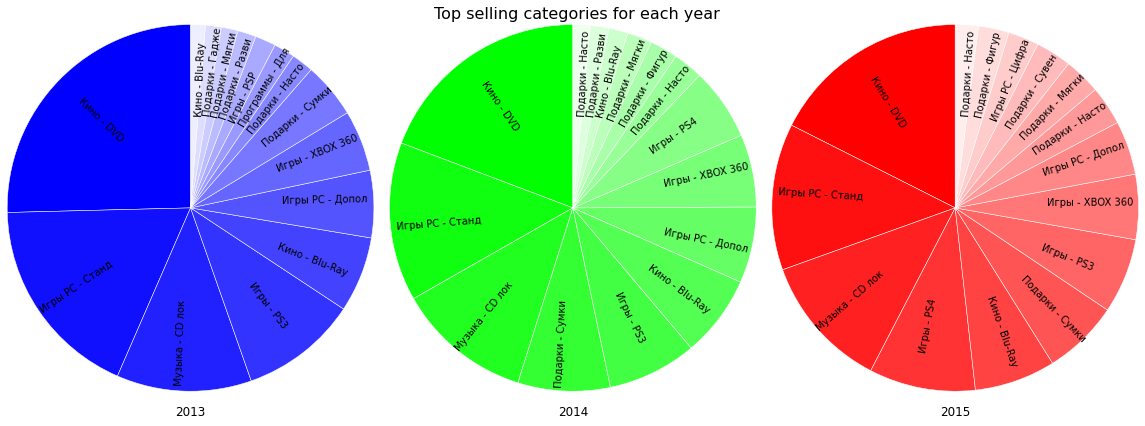

In [5]:
# Top N 
N=15

def get_ratio(year, topn, N):
    # Get total sold items for each year
    total = dfp.loc[year].item_cnt_year.sum()
    ratio = topn/total*100
    return "{0}: the total of the top {1} best selling items is {2} over a total of {3} for that year, which represents {4:.2f}%".format(year, N, topn, total, ratio)

dfp = sales[['date', 'item_id', 'item_cnt_day']].copy()
cats = item_categories.copy()

# Extract the year from the date column
dfp['year'] = pd.to_datetime(dfp['date'], format='%d.%m.%Y').dt.year
dfp.drop('date', axis=1, inplace=True)
dfp.item_cnt_day = dfp.item_cnt_day.astype(int)

# Remove returns
dfp = dfp[dfp.item_cnt_day>0]

# Add the category of each item
dfp = dfp.merge(items[['item_id','item_category_id']], how='left', on='item_id')

# Number of categories sold each year
dfp = dfp.groupby(['year', 'item_category_id'])\
       .agg({'item_cnt_day':'sum'})\
       .rename(columns={'item_cnt_day':'item_cnt_year'}, inplace=False)

# Top N categories sold 
top = dfp['item_cnt_year'].groupby('year', group_keys=False).nlargest(N).reset_index()
# Add category type to be plotted lated
top = top.merge(cats[['item_category_id','item_category_name']], how='left', on='item_category_id')

fig, axes = plt.subplots(1, 3, figsize=(16,6))

#Prepare colors for the top N
colors = [[] for i in range(3)]
for alpha in np.arange(N, 0, -1)/N:
    colors[0].append((0, 0, 1, alpha))
    colors[1].append((0, 1, 0, alpha))
    colors[2].append((1, 0, 0, alpha))
    
for ax, year, cs in zip(axes, years, colors):
    # Get top items for each year
    year_filter = top[top.year==year]
    plot_sizes = year_filter.item_cnt_year
    plot_labels = year_filter.item_category_name.str[:15]
    
    # Get the ratio
    print(get_ratio(year, plot_sizes.sum(), N))
    
    # Plot the pie
    ax.pie(plot_sizes, labels=plot_labels, radius=1.5, colors=cs,labeldistance=.5, rotatelabels=True, startangle=90, wedgeprops={"edgecolor":"1",'linewidth': .5})
    # Set titles below pies
    ax.set_title(year, y=-0.2)

# Space pies
fig.tight_layout()
fig.suptitle('Top selling categories for each year', fontsize=16)
plt.show()

del dfp

* Detecting outliers in item_price and item_cnt_day

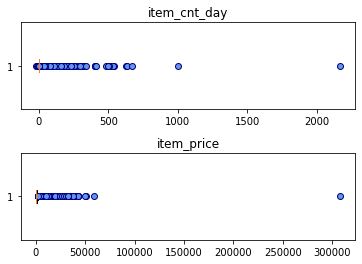

In [6]:
fig, axes = plt.subplots(2, 1)
plt.subplots_adjust(hspace=0.5)

flierprops = dict(marker='o', markerfacecolor='cornflowerblue', markersize=6, markeredgecolor='navy')

_ = axes[0].boxplot(x=sales.item_cnt_day, flierprops=flierprops, vert=False)
_ = axes[1].boxplot(x=sales.item_price, flierprops=flierprops, vert=False)

_ = axes[0].set_title('item_cnt_day')
_ = axes[1].set_title('item_price')

# Data preparation
* Removing outliers from item_price and item_cnt_day, and duplicate shops:

In [7]:
sales = sales[(sales.item_price<100000)&(sales.item_price>0)]
sales = sales[(sales.item_cnt_day>0)&(sales.item_cnt_day<1000)]

# Remove duplicate shops
sales.loc[sales.shop_id==0, 'shop_id'] = 57
test.loc[test.shop_id==0, 'shop_id'] = 57

sales.loc[sales.shop_id==1, 'shop_id'] = 58
test.loc[test.shop_id==1, 'shop_id'] = 58

sales.loc[sales.shop_id==10, 'shop_id'] = 11
test.loc[test.shop_id==10, 'shop_id'] = 11

* Add 'city' and 'category' to shops:\ -The first part of the shop_name is the city e.g.Serguiev Possad \ -The second part of the shop_name is the category e.g. ТЦ (shopping center)

In [8]:
# Correct the name of a shop
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name"] = 'СергиевПосад ТЦ "7Я"'
# The first part of the shop_name is the city e.g.Serguiev Possad
shops["shop_city"] = shops.shop_name.str.split(' ').map(lambda x: x[0])
# The second part of the shop_name is the category e.g. shopping center
shops["shop_category"] = shops.shop_name.str.split(" ").map(lambda x: x[1])
shops.loc[shops.shop_city == "!Якутск", "shop_city"] = "Якутск" 

# Feature Engineering

In [9]:
# Feature encoding
shops["shop_city"] = LabelEncoder().fit_transform(shops.shop_city)
shops["shop_category"] = LabelEncoder().fit_transform(shops.shop_category)
shops = shops[["shop_id", "shop_category", "shop_city"]]
shops.head()

,shop_id,shop_category,shop_city
0,0,4,29
1,1,8,29
2,2,8,0
3,3,6,1
4,4,8,2


* Add type and subtype to item_categories:

In [10]:
item_categories["category_type"] = item_categories.item_category_name.apply(lambda x: x.split(" ")[0]).astype(str)
# The category_type "Gamming" and "accesoires" becomes "Games"
item_categories.loc[(item_categories.category_type=="Игровые")|(item_categories.category_type=="Аксессуары"), "category_type"] = "Игры"
item_categories["split"] = item_categories.item_category_name.apply(lambda x: x.split("-"))
item_categories["category_subtype"] = item_categories.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())

# Feature Encoding

In [11]:
item_categories["category_type"] = LabelEncoder().fit_transform(item_categories.category_type)
item_categories["category_subtype"] = LabelEncoder().fit_transform(item_categories.category_subtype)
item_categories = item_categories[["item_category_id", "category_type", "category_subtype"]]
item_categories.head()

,item_category_id,category_type,category_subtype
0,0,0,29
1,1,3,9
2,2,3,10
3,3,3,11
4,4,3,13


* Compute monthly sales, in the same representation as the test data:

In [12]:
sales = sales.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)\
          .agg({'item_cnt_day':'sum'})\
          .rename(columns={'item_cnt_day':'item_cnt_month'}, inplace=False)
        
test['date_block_num'] = 34
test['item_cnt_month'] = 0
del test['ID']

df = sales.append(test)
df

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0
...,...,...,...,...
214195,34,45,18454,0.0
214196,34,45,16188,0.0
214197,34,45,15757,0.0
214198,34,45,19648,0.0


## Create a feature matrix:

In [13]:
matrix = []

for num in df['date_block_num'].unique(): 
    tmp = df[df.date_block_num==num]
    matrix.append(np.array(list(product([num], tmp.shop_id.unique(), tmp.item_id.unique())), dtype='int16'))

# Turn the grid into a dataframe
matrix = pd.DataFrame(np.vstack(matrix), columns=['date_block_num', 'shop_id', 'item_id'], dtype=np.int16)

# Add the features from sales data to the matrix
matrix = matrix.merge(df, how='left', on=['date_block_num', 'shop_id', 'item_id']).fillna(0)

#Merge features from shops, items and item_categories:
matrix = matrix.merge(shops, how='left', on='shop_id')
matrix = matrix.merge(items[['item_id','item_category_id']], how='left', on='item_id')
matrix = matrix.merge(item_categories, how='left', on='item_category_id')

# Add month
matrix['month'] = matrix.date_block_num%12
# Clip counts
matrix['item_cnt_month'] = matrix['item_cnt_month'].clip(0, 20)

In [14]:
# Set columns types to control the matrix' size
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix['month'] = matrix['month'].astype(np.int8)
matrix['item_cnt_month'] = matrix['item_cnt_month'].astype(np.int32)
matrix['shop_category'] = matrix['shop_category'].astype(np.int8)
matrix['shop_city'] = matrix['shop_city'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['category_type'] = matrix['category_type'].astype(np.int8)
matrix['category_subtype'] = matrix['category_subtype'].astype(np.int8)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,category_type,category_subtype,month
0,0,2,27,1,8,0,19,3,10,0
1,0,2,33,1,8,0,37,5,1,0
2,0,2,317,1,8,0,45,6,23,0
3,0,2,438,1,8,0,45,6,23,0
4,0,2,471,2,8,0,49,6,39,0
...,...,...,...,...,...,...,...,...,...,...
11098703,34,45,18454,0,8,20,55,7,2,10
11098704,34,45,16188,0,8,20,64,8,42,10
11098705,34,45,15757,0,8,20,55,7,2,10
11098706,34,45,19648,0,8,20,40,5,4,10


In [15]:
print('{0:.2f}'.format(matrix.memory_usage(index=False, deep=True).sum()/(2**20)), 'MB')

148.18 MB


# Feature Engineering
### Lagged Features

In [16]:
def lag_feature(df, lags, col):
    print(col)
    for i in lags:
        shifted = df[["date_block_num", "shop_id", "item_id", col]].copy()
        shifted.columns = ["date_block_num", "shop_id", "item_id", col+"_lag_"+str(i)]
        shifted.date_block_num += i
        df = df.merge(shifted, on=['date_block_num','shop_id','item_id'], how='left').fillna(0)
    return df

In [17]:
# lag the target item_cnt_month
matrix = lag_feature(matrix, [1, 2, 3, 4, 5, 12], 'item_cnt_month')

item_cnt_month


In [18]:
# shop/date_block_num aggregates lags
gb = matrix.groupby(['shop_id', 'date_block_num'],as_index=False)\
          .agg({'item_cnt_month':'sum'})\
          .rename(columns={'item_cnt_month':'cnt_block_shop'}, inplace=False)
matrix = matrix.merge(gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)
matrix = lag_feature(matrix, [1, 2, 3, 4, 5, 12], 'cnt_block_shop')
matrix.drop('cnt_block_shop', axis=1, inplace=True)

cnt_block_shop


In [19]:
# item/date_block_num aggregates lags
gb = matrix.groupby(['item_id', 'date_block_num'],as_index=False)\
          .agg({'item_cnt_month':'sum'})\
          .rename(columns={'item_cnt_month':'cnt_block_item'}, inplace=False)
matrix = matrix.merge(gb, how='left', on=['item_id', 'date_block_num']).fillna(0)
matrix = lag_feature(matrix, [1, 2, 3, 4, 5, 12], 'cnt_block_item')
matrix.drop('cnt_block_item', axis=1, inplace=True)

cnt_block_item


In [20]:
# category/date_block_num aggregates lags
gb = matrix.groupby(['category_type', 'date_block_num'],as_index=False)\
          .agg({'item_cnt_month':'sum'})\
          .rename(columns={'item_cnt_month':'cnt_block_category'}, inplace=False)
matrix = matrix.merge(gb, how='left', on=['category_type', 'date_block_num']).fillna(0)
matrix = lag_feature(matrix, [1, 2, 3, 4, 5, 12], 'cnt_block_category')
matrix.drop('cnt_block_category', axis=1, inplace=True)

cnt_block_category


In [21]:
matrix.to_csv('matrix.csv', index=False)
# matrix = pd.read_csv('matrix.csv')
matrix

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,category_type,category_subtype,month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_12,cnt_block_shop_lag_1,cnt_block_shop_lag_2,cnt_block_shop_lag_3,cnt_block_shop_lag_4,cnt_block_shop_lag_5,cnt_block_shop_lag_12,cnt_block_item_lag_1,cnt_block_item_lag_2,cnt_block_item_lag_3,cnt_block_item_lag_4,cnt_block_item_lag_5,cnt_block_item_lag_12,cnt_block_category_lag_1,cnt_block_category_lag_2,cnt_block_category_lag_3,cnt_block_category_lag_4,cnt_block_category_lag_5,cnt_block_category_lag_12
0,0,2,27,1,8,0,19,3,10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2,33,1,8,0,37,5,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,317,1,8,0,45,6,23,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2,438,1,8,0,45,6,23,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2,471,2,8,0,49,6,39,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098703,34,45,18454,0,8,20,55,7,2,10,1.0,0.0,0.0,0.0,0.0,0.0,686.0,658.0,711.0,675.0,626.0,0.0,2.0,1.0,3.0,12.0,19.0,0.0,6824.0,6113.0,6970.0,7621.0,7164.0,0.0
11098704,34,45,16188,0,8,20,64,8,42,10,0.0,0.0,0.0,0.0,0.0,0.0,686.0,658.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,12302.0,8847.0,0.0,0.0,0.0,0.0
11098705,34,45,15757,0,8,20,55,7,2,10,0.0,0.0,0.0,0.0,0.0,0.0,686.0,658.0,711.0,675.0,626.0,1146.0,5.0,3.0,4.0,4.0,8.0,9.0,6824.0,6113.0,6970.0,7621.0,7164.0,11613.0
11098706,34,45,19648,0,8,20,40,5,4,10,0.0,0.0,0.0,0.0,0.0,0.0,686.0,658.0,711.0,675.0,626.0,0.0,2.0,3.0,7.0,2.0,4.0,0.0,12937.0,11178.0,13028.0,13748.0,14059.0,0.0


# Label mean encodings
* Mean encoding and scaling : first split the data into Train and Validation, estimate encodings on Train, then apply them to Validation set:

In [22]:
from sklearn.preprocessing import StandardScaler

def standard_mean_enc(df, col):
    mean_enc = df.groupby(col).agg({'item_cnt_month': 'mean'})
    scaler = StandardScaler().fit(mean_enc)
    return {v: k[0] for v, k in enumerate(scaler.transform(mean_enc))}

In [23]:
cols_to_mean_encode = ['shop_category', 'shop_city', 'item_category_id', 'category_type', 'category_subtype']

for col in cols_to_mean_encode:
    # Train on the train data
    mean_enc = standard_mean_enc(matrix[matrix.date_block_num < 33].copy(), col) # X_train, y_train
    # Apply to Train, Validation and Test
    matrix[col] = matrix[col].map(mean_enc)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,category_type,category_subtype,month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_12,cnt_block_shop_lag_1,cnt_block_shop_lag_2,cnt_block_shop_lag_3,cnt_block_shop_lag_4,cnt_block_shop_lag_5,cnt_block_shop_lag_12,cnt_block_item_lag_1,cnt_block_item_lag_2,cnt_block_item_lag_3,cnt_block_item_lag_4,cnt_block_item_lag_5,cnt_block_item_lag_12,cnt_block_category_lag_1,cnt_block_category_lag_2,cnt_block_category_lag_3,cnt_block_category_lag_4,cnt_block_category_lag_5,cnt_block_category_lag_12
0,0,2,27,1,-0.066494,-0.939512,0.010498,-0.266094,-0.054087,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2,33,1,-0.066494,-0.939512,-0.314769,-0.661533,-0.318815,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,317,1,-0.066494,-0.939512,-0.374076,-0.745716,-0.372734,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2,438,1,-0.066494,-0.939512,-0.374076,-0.745716,-0.372734,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2,471,2,-0.066494,-0.939512,-0.297896,-0.745716,-0.304462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098703,34,45,18454,0,-0.066494,-0.569461,-0.285105,-0.701985,-0.292999,10,1.0,0.0,0.0,0.0,0.0,0.0,686.0,658.0,711.0,675.0,626.0,0.0,2.0,1.0,3.0,12.0,19.0,0.0,6824.0,6113.0,6970.0,7621.0,7164.0,0.0
11098704,34,45,16188,0,-0.066494,-0.569461,-0.228197,-0.594150,-0.241999,10,0.0,0.0,0.0,0.0,0.0,0.0,686.0,658.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,12302.0,8847.0,0.0,0.0,0.0,0.0
11098705,34,45,15757,0,-0.066494,-0.569461,-0.285105,-0.701985,-0.292999,10,0.0,0.0,0.0,0.0,0.0,0.0,686.0,658.0,711.0,675.0,626.0,1146.0,5.0,3.0,4.0,4.0,8.0,9.0,6824.0,6113.0,6970.0,7621.0,7164.0,11613.0
11098706,34,45,19648,0,-0.066494,-0.569461,-0.273028,-0.661533,-0.282176,10,0.0,0.0,0.0,0.0,0.0,0.0,686.0,658.0,711.0,675.0,626.0,0.0,2.0,3.0,7.0,2.0,4.0,0.0,12937.0,11178.0,13028.0,13748.0,14059.0,0.0


# Splitting Data

In [24]:
# Remove the 2013's sales data
matrix = matrix[matrix.date_block_num>=12] 
matrix.reset_index(drop=True, inplace=True)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,category_type,category_subtype,month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_12,cnt_block_shop_lag_1,cnt_block_shop_lag_2,cnt_block_shop_lag_3,cnt_block_shop_lag_4,cnt_block_shop_lag_5,cnt_block_shop_lag_12,cnt_block_item_lag_1,cnt_block_item_lag_2,cnt_block_item_lag_3,cnt_block_item_lag_4,cnt_block_item_lag_5,cnt_block_item_lag_12,cnt_block_category_lag_1,cnt_block_category_lag_2,cnt_block_category_lag_3,cnt_block_category_lag_4,cnt_block_category_lag_5,cnt_block_category_lag_12
0,12,2,32,1,-0.066494,-0.939512,-0.273028,-0.661533,-0.282176,0,0.0,0.0,0.0,0.0,0.0,0.0,1259.0,815.0,718.0,846.0,852.0,1151.0,90.0,81.0,58.0,59.0,72.0,242.0,40880.0,33642.0,31822.0,31863.0,34539.0,41146.0
1,12,2,33,1,-0.066494,-0.939512,-0.314769,-0.661533,-0.318815,0,1.0,2.0,0.0,0.0,0.0,1.0,1259.0,815.0,718.0,846.0,852.0,1151.0,42.0,15.0,33.0,43.0,36.0,61.0,40880.0,33642.0,31822.0,31863.0,34539.0,41146.0
2,12,2,99,1,-0.066494,-0.939512,-0.314769,-0.661533,-0.318815,0,0.0,0.0,0.0,0.0,0.0,0.0,1259.0,815.0,0.0,0.0,0.0,0.0,24.0,2.0,0.0,0.0,0.0,0.0,40880.0,33642.0,0.0,0.0,0.0,0.0
3,12,2,482,2,-0.066494,-0.939512,-0.146057,-0.658236,-0.168385,0,1.0,2.0,1.0,2.0,0.0,1.0,1259.0,815.0,718.0,846.0,852.0,1151.0,89.0,86.0,131.0,90.0,64.0,119.0,2837.0,2676.0,2734.0,2634.0,2417.0,3995.0
4,12,2,485,1,-0.066494,-0.939512,-0.146057,-0.658236,-0.168385,0,1.0,0.0,4.0,2.0,0.0,0.0,1259.0,815.0,718.0,846.0,852.0,0.0,111.0,151.0,172.0,160.0,135.0,0.0,2837.0,2676.0,2734.0,2634.0,2417.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6619859,34,45,18454,0,-0.066494,-0.569461,-0.285105,-0.701985,-0.292999,10,1.0,0.0,0.0,0.0,0.0,0.0,686.0,658.0,711.0,675.0,626.0,0.0,2.0,1.0,3.0,12.0,19.0,0.0,6824.0,6113.0,6970.0,7621.0,7164.0,0.0
6619860,34,45,16188,0,-0.066494,-0.569461,-0.228197,-0.594150,-0.241999,10,0.0,0.0,0.0,0.0,0.0,0.0,686.0,658.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,12302.0,8847.0,0.0,0.0,0.0,0.0
6619861,34,45,15757,0,-0.066494,-0.569461,-0.285105,-0.701985,-0.292999,10,0.0,0.0,0.0,0.0,0.0,0.0,686.0,658.0,711.0,675.0,626.0,1146.0,5.0,3.0,4.0,4.0,8.0,9.0,6824.0,6113.0,6970.0,7621.0,7164.0,11613.0
6619862,34,45,19648,0,-0.066494,-0.569461,-0.273028,-0.661533,-0.282176,10,0.0,0.0,0.0,0.0,0.0,0.0,686.0,658.0,711.0,675.0,626.0,0.0,2.0,3.0,7.0,2.0,4.0,0.0,12937.0,11178.0,13028.0,13748.0,14059.0,0.0


In [25]:
X_train = matrix[matrix.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = matrix[matrix.date_block_num < 33]['item_cnt_month']
X_val = matrix[matrix.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_val =  matrix[matrix.date_block_num == 33]['item_cnt_month']
X_test = matrix[matrix.date_block_num == 34].drop(['item_cnt_month'], axis=1)

### Removing Few Columns

In [26]:
X_train.drop('date_block_num', axis=1, inplace=True)
X_val.drop('date_block_num', axis=1, inplace=True)
X_test.drop('date_block_num', axis=1, inplace=True)

# Hyper Parameters Tuning

In [27]:
splits = []
for block in [27, 28, 29, 30, 31, 32]:
    train_idxs = matrix[matrix.date_block_num < block].index.values
    test_idxs = matrix[matrix.date_block_num == block].index.values
    splits.append((train_idxs, test_idxs))
splits

[(array([      0,       1,       2, ..., 4808154, 4808155, 4808156]),
  array([4808157, 4808158, 4808159, ..., 5054439, 5054440, 5054441])),
 (array([      0,       1,       2, ..., 5054439, 5054440, 5054441]),
  array([5054442, 5054443, 5054444, ..., 5286891, 5286892, 5286893])),
 (array([      0,       1,       2, ..., 5286891, 5286892, 5286893]),
  array([5286894, 5286895, 5286896, ..., 5511007, 5511008, 5511009])),
 (array([      0,       1,       2, ..., 5511007, 5511008, 5511009]),
  array([5511010, 5511011, 5511012, ..., 5739681, 5739682, 5739683])),
 (array([      0,       1,       2, ..., 5739681, 5739682, 5739683]),
  array([5739684, 5739685, 5739686, ..., 5954091, 5954092, 5954093])),
 (array([      0,       1,       2, ..., 5954091, 5954092, 5954093]),
  array([5954094, 5954095, 5954096, ..., 6167577, 6167578, 6167579]))]

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

hyper_params = {'max_depth': [3, 4, 5, 6, 7, 8, 9], 
                'gamma': [0, 0.5, 1, 1.5, 2, 5], 
                'subsample': [0.6, 0.7, 0.8, 0.9, 1], 
                'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                'learning_rate': [0.01, 0.1, 0.2, 0.3],
                'max_bin' : [256, 512, 1024]
               }

xgbr = XGBRegressor(seed = 42, tree_method = "gpu_hist") #hist
clf = RandomizedSearchCV(estimator = xgbr, 
                   param_distributions = hyper_params,
                   n_iter = 500,
                   scoring = 'neg_root_mean_squared_error',
                   cv = splits,
                   n_jobs=1, 
                   verbose=3)
clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", -clf.best_score_)

Fitting 6 folds for each of 500 candidates, totalling 3000 fits
[CV] subsample=0.9, max_depth=9, max_bin=1024, learning_rate=0.1, gamma=5, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.9, max_depth=9, max_bin=1024, learning_rate=0.1, gamma=5, colsample_bytree=0.7, score=-0.909, total=  18.6s
[CV] subsample=0.9, max_depth=9, max_bin=1024, learning_rate=0.1, gamma=5, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.6s remaining:    0.0s


[CV]  subsample=0.9, max_depth=9, max_bin=1024, learning_rate=0.1, gamma=5, colsample_bytree=0.7, score=-0.836, total=  15.4s
[CV] subsample=0.9, max_depth=9, max_bin=1024, learning_rate=0.1, gamma=5, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   34.0s remaining:    0.0s


[CV]  subsample=0.9, max_depth=9, max_bin=1024, learning_rate=0.1, gamma=5, colsample_bytree=0.7, score=-0.777, total=  15.6s
[CV] subsample=0.9, max_depth=9, max_bin=1024, learning_rate=0.1, gamma=5, colsample_bytree=0.7 
[CV]  subsample=0.9, max_depth=9, max_bin=1024, learning_rate=0.1, gamma=5, colsample_bytree=0.7, score=-0.699, total=  15.9s
[CV] subsample=0.9, max_depth=9, max_bin=1024, learning_rate=0.1, gamma=5, colsample_bytree=0.7 
[CV]  subsample=0.9, max_depth=9, max_bin=1024, learning_rate=0.1, gamma=5, colsample_bytree=0.7, score=-0.765, total=  16.3s
[CV] subsample=0.9, max_depth=9, max_bin=1024, learning_rate=0.1, gamma=5, colsample_bytree=0.7 
[CV]  subsample=0.9, max_depth=9, max_bin=1024, learning_rate=0.1, gamma=5, colsample_bytree=0.7, score=-0.887, total=  16.8s
[CV] subsample=1, max_depth=4, max_bin=1024, learning_rate=0.3, gamma=2, colsample_bytree=0.5 
[CV]  subsample=1, max_depth=4, max_bin=1024, learning_rate=0.3, gamma=2, colsample_bytree=0.5, score=-0.921, 

[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed: 519.5min finished


Best parameters: {'subsample': 1, 'max_depth': 9, 'max_bin': 256, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.6}
Lowest RMSE:  0.8100076701972645


# Model Evaluation

## Linear Regression

In [29]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
yhat_val_lr = lr.predict(X_val).clip(0, 20)
print('Validation RMSE:', mean_squared_error(y_val, yhat_val_lr, squared=False)) #Validation RMSE: 0.9645168655662343
yhat_test_lr = lr.predict(X_test).clip(0, 20)

Validation RMSE: 0.9645168655662204


# XGBoost

In [30]:
ts = time.time()

xgb = XGBRegressor(seed = 42, 
    tree_method = "gpu_hist",
    subsample = 0.9,
    max_depth = 9,
    learning_rate = 0.1,
    gamma = 2,
    colsample_bytree = 0.9
    )
xgb.fit(
    X_train,y_train,
    eval_metric="rmse",
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True,
    early_stopping_rounds = 10
    )
print('Training took: {0}s'.format(time.time()-ts))
yhat_val_xgb = xgb.predict(X_val).clip(0, 20)
print('Valdation RMSE:', mean_squared_error(y_val, yhat_val_xgb, squared=False))
yhat_test_xgb = xgb.predict(X_test).clip(0, 20)

[0]	validation_0-rmse:1.15445	validation_1-rmse:1.12021
[1]	validation_0-rmse:1.10714	validation_1-rmse:1.08560
[2]	validation_0-rmse:1.06686	validation_1-rmse:1.05740
[3]	validation_0-rmse:1.03252	validation_1-rmse:1.03294
[4]	validation_0-rmse:1.00326	validation_1-rmse:1.01489
[5]	validation_0-rmse:0.97821	validation_1-rmse:0.99907
[6]	validation_0-rmse:0.95720	validation_1-rmse:0.98637
[7]	validation_0-rmse:0.93908	validation_1-rmse:0.97640
[8]	validation_0-rmse:0.92407	validation_1-rmse:0.96820
[9]	validation_0-rmse:0.91083	validation_1-rmse:0.96188
[10]	validation_0-rmse:0.89953	validation_1-rmse:0.95699
[11]	validation_0-rmse:0.88885	validation_1-rmse:0.95322
[12]	validation_0-rmse:0.88023	validation_1-rmse:0.94972
[13]	validation_0-rmse:0.87270	validation_1-rmse:0.94725
[14]	validation_0-rmse:0.86608	validation_1-rmse:0.94539
[15]	validation_0-rmse:0.85943	validation_1-rmse:0.94355
[16]	validation_0-rmse:0.85405	validation_1-rmse:0.94229
[17]	validation_0-rmse:0.84948	validation

* Serialize and Deserialize the XGBoost model with Pickle:

# Importing Pickle

In [31]:
import pickle
pickle.dump(xgb, open("xgboost.pickle.dat", "wb"))
#loaded_model = pickle.load(open("xgboost_base.pickle.dat", "rb"))

# Ploting XGBoost Feaure Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

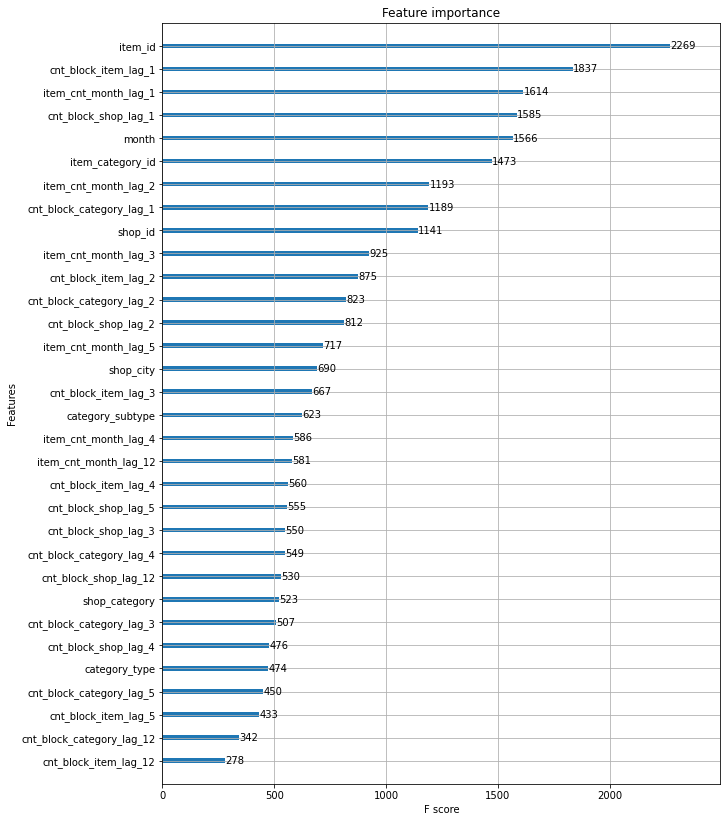

In [32]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(xgb, (10,14))

# Esembling
## Meta Features

In [33]:
y_train_meta = matrix[matrix.date_block_num.isin([27, 28, 29, 30, 31, 32])].item_cnt_month

In [34]:
X_train_meta = [[],[]]
for block in [27, 28, 29, 30, 31, 32]:
    print('Block:', block)
    # X and y Train for blocks from 12 to block
    X_train_block = matrix[matrix.date_block_num < block].drop(['date_block_num', 'item_cnt_month'], axis=1)
    y_train_block = matrix[matrix.date_block_num < block].item_cnt_month
    # X and y Test for block
    X_val_block = matrix[matrix.date_block_num == block].drop(['date_block_num', 'item_cnt_month'], axis=1)
    #y_test_block = matrix[matrix.date_block_num == block].item_cnt_month
    
    # Fit first model 
    print(' LR fitting ...')
    lr.fit(X_train_block, y_train_block)
    print(' LR fitting ... done')
    # Append prediction results on X_val_block to X_train_meta (first column)
    X_train_meta[0] += list(lr.predict(X_val_block).clip(0, 20))
    
    # Fit second model
    print(' XGB fitting ...')
    xgb.fit(
        X_train_block, y_train_block,
        eval_metric="rmse",
        eval_set=[(X_train_block, y_train_block)],
        #eval_set=[(X_train_block, y_train_block), (X_val_block, y_test_block)],
        verbose=0,
        early_stopping_rounds = 10
    )
    print(' XGB fitting ... done')
    # Append prediction results on X_val_block to X_train_meta (second column)
    X_train_meta[1] += list(xgb.predict(X_val_block).clip(0, 20))
# Turn list into dataframe
X_train_meta = pd.DataFrame({'yhat_lr': X_train_meta[0], 'yhat_xgb': X_train_meta[1]})

Block: 27
 LR fitting ...
 LR fitting ... done
 XGB fitting ...
 XGB fitting ... done
Block: 28
 LR fitting ...
 LR fitting ... done
 XGB fitting ...
 XGB fitting ... done
Block: 29
 LR fitting ...
 LR fitting ... done
 XGB fitting ...
 XGB fitting ... done
Block: 30
 LR fitting ...
 LR fitting ... done
 XGB fitting ...
 XGB fitting ... done
Block: 31
 LR fitting ...
 LR fitting ... done
 XGB fitting ...
 XGB fitting ... done
Block: 32
 LR fitting ...
 LR fitting ... done
 XGB fitting ...
 XGB fitting ... done


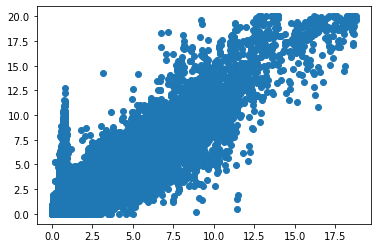

In [35]:
plt.scatter(X_train_meta.yhat_lr, X_train_meta.yhat_xgb)

# Stacking

In [36]:
stacking = LinearRegression()
stacking.fit(X_train_meta, y_train_meta)

#Squared: If True returns MSE value, if False returns RMSE value.
yhat_train_meta = stacking.predict(X_train_meta).clip(0, 20)
print('Meta Training RMSE:', mean_squared_error(y_train_meta, yhat_train_meta, squared=False))
# Meta Training RMSE: 0.813971713370181

yhat_val_meta = stacking.predict(np.vstack((yhat_val_lr, yhat_val_xgb)).T).clip(0, 20)
print('Meta Validation RMSE:', mean_squared_error(y_val, yhat_val_meta, squared=False))
# Meta Validation RMSE: 0.9184725317670576

yhat_test_meta = stacking.predict(np.vstack((yhat_test_lr, yhat_test_xgb)).T).clip(0, 20)

Meta Training RMSE: 0.8133424861738745
Meta Validation RMSE: 0.9218473774621058


# Submission

In [37]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": yhat_test_meta
})
submission.to_csv('submission_stacking.csv', index=False)
# Public score 0.92466